In [124]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostRegressor
from tqdm import tqdm

warnings.filterwarnings('ignore')

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")
age_gender_info = pd.read_csv("./data/age_gender_info.csv")
age_gender_spec = pd.DataFrame(age_gender_info['지역'])
population = pd.read_csv('./data/population.csv')
population.columns = ['지역','인구수']
age_gender_spec['2060'] = age_gender_info[['20대(남자)','20대(여자)','30대(남자)','30대(여자)',
                                          '40대(남자)','40대(여자)','50대(남자)','50대(여자)',
                                          '60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
age_gender_spec = age_gender_spec.merge(population, on='지역')
age_gender_spec['생산가능인구'] = np.round(age_gender_spec['인구수'] * age_gender_spec['2060'])
# age_gender_spec['4050'] = age_gender_info[['40대(남자)','40대(여자)','50대(남자)','50대(여자)']].sum(axis=1)
# age_gender_spec['6070'] = age_gender_info[['60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

categorial_variable = ["임대건물구분", "지역", "공급유형", "자격유형"]
continious_variable = ["총세대수", "전용면적", "전용면적별세대수", "공가수", "임대보증금", "임대료",
                       "단지내주차면수"]



# test_x_unique
# gbr: 72.57647194273466
# rfr: 19.73668358714044
# {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100} -62.07652539964124
# 144.17 143.65

In [155]:
def sorter(column):
    test_index = pd.Categorical(column,categories=pd.unique(test['단지코드']),ordered=True)
    return pd.Series(test_index)


def pre_processing(x, flag):
    x = x.fillna(0)
    x.loc[x['임대료'] == '-', ['임대료']] = 0
    x.loc[x['임대보증금'] == '-', ['임대보증금']] = 0
    x[['임대료', '임대보증금']] = x[['임대료', '임대보증금']].astype('int64')

    x['전용면적'] = x['전용면적'] // 5 * 5
    idx = x[x['전용면적'] > 100].index
    x.loc[idx, '전용면적'] = 100
    idx = x[x['전용면적'] < 15].index
    x.loc[idx, '전용면적'] = 15
    columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스', '공급유형', '임대건물구분', '자격유형']
    target = "등록차량수"
    area_columns = []
    for area in x['전용면적'].unique():
        area_columns.append(f'면적_{area}')

    new_x = pd.DataFrame()
    for i, code in tqdm(enumerate(x['단지코드'].unique())):
        temp = x[x['단지코드'] == code]
        temp.index = range(temp.shape[0])
        for col in columns:
            new_x.loc[i, col] = temp.loc[0, col]

        for col in area_columns:
            area = float(col.split('_')[-1])
            new_x.loc[i, col] = temp[temp['전용면적'] == area]['전용면적별세대수'].sum()

        if flag == True:
            new_x.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
    new_x = new_x.merge(age_gender_spec[['지역','2060']], on='지역', sort=False)
    new_x = pd.get_dummies(new_x, columns=categorial_variable)
    new_x = new_x[[c for c in new_x if c not in ['등록차량수']] + [c for c in ['등록차량수'] if c in new_x]]
    # scaler = RobustScaler()
    # x[continious_variable] = scaler.fit_transform(x[continious_variable])
    return new_x

differ_variables = ['공급유형_공공임대(5년)', '공급유형_공공임대(10년)', '자격유형_B', '자격유형_F',
                    '지역_서울특별시', '공급유형_공공분양', '공급유형_장기전세', '자격유형_D',
                    '면적_65.0']

if len(test[test['자격유형'].isnull() == True]) > 0:
    test.loc[test['자격유형'].isnull() == True, ['자격유형']] = ('A', 'C')

new_train = pre_processing(train, True)
new_test = pre_processing(test, False)


423it [00:07, 58.32it/s]
150it [00:02, 64.22it/s]


In [161]:
new_test = new_test.sort_values(by="단지코드", key=sorter)
for c in differ_variables:
    new_test[c] = 0

x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:, -1]
x_test = new_test.iloc[:, 1:]

rfr = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=1,
                            min_samples_split=4, random_state=46)
cbr = CatBoostRegressor(loss_function='MAE', random_state=44)
model = cbr
train_X, test_X, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2, random_state=93)

new_test

,단지코드,총세대수,공가수,단지내주차면수,지하철,버스,면적_35.0,면적_45.0,면적_50.0,면적_30.0,...,자격유형_M,자격유형_N,공급유형_공공임대(5년),자격유형_B,자격유형_F,지역_서울특별시,공급유형_공공분양,공급유형_장기전세,자격유형_D,면적_65.0
0,C1072,754.0,14.0,683.0,0.0,2.0,116.0,262.0,376.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,C1128,1354.0,9.0,1216.0,0.0,3.0,420.0,356.0,578.0,0.0,...,0,0,0,0,0,0,0,0,0,0
36,C1456,619.0,18.0,547.0,0.0,16.0,165.0,196.0,132.0,82.0,...,0,0,0,0,0,0,0,0,0,0
44,C1840,593.0,7.0,543.0,0.0,3.0,335.0,174.0,84.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,C1332,1297.0,11.0,1112.0,0.0,2.0,425.0,568.0,304.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,C2456,349.0,17.0,270.0,0.0,4.0,138.0,96.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
129,C1266,596.0,35.0,593.0,0.0,1.0,304.0,107.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
98,C2152,120.0,9.0,40.0,0.0,1.0,0.0,0.0,0.0,54.0,...,0,0,0,0,0,0,0,0,0,0
66,C1267,675.0,38.0,467.0,0.0,1.0,126.0,180.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
model.fit(train_X, train_y)
pred = model.predict(test_X)
print(mean_absolute_error(test_y, pred))


0:	learn: 274.6705317	total: 2.34ms	remaining: 2.33s
1:	learn: 269.0678342	total: 4.49ms	remaining: 2.24s
2:	learn: 264.3625018	total: 6.2ms	remaining: 2.06s
3:	learn: 259.7643290	total: 7.8ms	remaining: 1.94s
4:	learn: 255.3353323	total: 9.53ms	remaining: 1.9s
5:	learn: 250.6998010	total: 11.1ms	remaining: 1.85s
6:	learn: 246.5913902	total: 13ms	remaining: 1.84s
7:	learn: 241.6418881	total: 14.7ms	remaining: 1.82s
8:	learn: 238.1937068	total: 16.3ms	remaining: 1.8s
9:	learn: 234.0036383	total: 18.2ms	remaining: 1.8s
10:	learn: 230.2392904	total: 19.7ms	remaining: 1.77s
11:	learn: 227.0475743	total: 21.4ms	remaining: 1.76s
12:	learn: 223.7618869	total: 23ms	remaining: 1.75s
13:	learn: 220.3987278	total: 24.8ms	remaining: 1.75s
14:	learn: 217.5489811	total: 26.5ms	remaining: 1.74s
15:	learn: 214.3059783	total: 28.4ms	remaining: 1.74s
16:	learn: 211.5181943	total: 30ms	remaining: 1.73s
17:	learn: 208.8139331	total: 31.6ms	remaining: 1.72s
18:	learn: 205.8047050	total: 33.4ms	remaining: 1

181:	learn: 79.7339728	total: 305ms	remaining: 1.37s
182:	learn: 79.3993972	total: 307ms	remaining: 1.37s
183:	learn: 79.2012883	total: 309ms	remaining: 1.37s
184:	learn: 78.9883911	total: 312ms	remaining: 1.37s
185:	learn: 78.8772528	total: 314ms	remaining: 1.37s
186:	learn: 78.5637101	total: 316ms	remaining: 1.37s
187:	learn: 78.4125301	total: 318ms	remaining: 1.37s
188:	learn: 78.2650932	total: 320ms	remaining: 1.37s
189:	learn: 77.8489496	total: 321ms	remaining: 1.37s
190:	learn: 77.7250076	total: 324ms	remaining: 1.37s
191:	learn: 77.4112330	total: 326ms	remaining: 1.37s
192:	learn: 77.1905898	total: 328ms	remaining: 1.37s
193:	learn: 76.8526715	total: 329ms	remaining: 1.37s
194:	learn: 76.4255471	total: 331ms	remaining: 1.37s
195:	learn: 76.2511342	total: 333ms	remaining: 1.36s
196:	learn: 76.0163204	total: 335ms	remaining: 1.36s
197:	learn: 75.8065088	total: 336ms	remaining: 1.36s
198:	learn: 75.7094468	total: 338ms	remaining: 1.36s
199:	learn: 75.4926557	total: 339ms	remaining:

356:	learn: 52.2539464	total: 610ms	remaining: 1.1s
357:	learn: 52.1009397	total: 612ms	remaining: 1.1s
358:	learn: 52.0397186	total: 614ms	remaining: 1.09s
359:	learn: 51.9602975	total: 616ms	remaining: 1.09s
360:	learn: 51.6633467	total: 619ms	remaining: 1.09s
361:	learn: 51.5821070	total: 621ms	remaining: 1.09s
362:	learn: 51.4110558	total: 623ms	remaining: 1.09s
363:	learn: 51.3942315	total: 625ms	remaining: 1.09s
364:	learn: 51.2911226	total: 627ms	remaining: 1.09s
365:	learn: 51.1508528	total: 628ms	remaining: 1.09s
366:	learn: 51.0532637	total: 630ms	remaining: 1.09s
367:	learn: 51.0045011	total: 632ms	remaining: 1.08s
368:	learn: 50.8867642	total: 634ms	remaining: 1.08s
369:	learn: 50.8301536	total: 636ms	remaining: 1.08s
370:	learn: 50.6985016	total: 638ms	remaining: 1.08s
371:	learn: 50.6154989	total: 639ms	remaining: 1.08s
372:	learn: 50.4888102	total: 641ms	remaining: 1.08s
373:	learn: 50.4295504	total: 643ms	remaining: 1.08s
374:	learn: 50.3382990	total: 645ms	remaining: 1

518:	learn: 39.9675127	total: 920ms	remaining: 853ms
519:	learn: 39.8745849	total: 922ms	remaining: 851ms
520:	learn: 39.8611879	total: 924ms	remaining: 850ms
521:	learn: 39.8519441	total: 926ms	remaining: 848ms
522:	learn: 39.7727315	total: 928ms	remaining: 847ms
523:	learn: 39.7572422	total: 930ms	remaining: 845ms
524:	learn: 39.6910948	total: 932ms	remaining: 843ms
525:	learn: 39.6299524	total: 934ms	remaining: 841ms
526:	learn: 39.6067302	total: 935ms	remaining: 839ms
527:	learn: 39.5626128	total: 937ms	remaining: 838ms
528:	learn: 39.5501398	total: 939ms	remaining: 836ms
529:	learn: 39.5363423	total: 941ms	remaining: 834ms
530:	learn: 39.4995706	total: 942ms	remaining: 832ms
531:	learn: 39.4376290	total: 944ms	remaining: 830ms
532:	learn: 39.3784960	total: 945ms	remaining: 828ms
533:	learn: 39.3570354	total: 947ms	remaining: 827ms
534:	learn: 39.3191983	total: 949ms	remaining: 825ms
535:	learn: 39.2471908	total: 950ms	remaining: 823ms
536:	learn: 39.2317454	total: 952ms	remaining:

691:	learn: 32.6397736	total: 1.23s	remaining: 546ms
692:	learn: 32.5607478	total: 1.23s	remaining: 544ms
693:	learn: 32.5396675	total: 1.23s	remaining: 542ms
694:	learn: 32.5204408	total: 1.23s	remaining: 540ms
695:	learn: 32.5082335	total: 1.23s	remaining: 539ms
696:	learn: 32.4532928	total: 1.24s	remaining: 537ms
697:	learn: 32.4306592	total: 1.24s	remaining: 536ms
698:	learn: 32.3639034	total: 1.24s	remaining: 534ms
699:	learn: 32.3326070	total: 1.24s	remaining: 532ms
700:	learn: 32.2985004	total: 1.24s	remaining: 530ms
701:	learn: 32.2777988	total: 1.24s	remaining: 528ms
702:	learn: 32.2570576	total: 1.25s	remaining: 527ms
703:	learn: 32.2206802	total: 1.25s	remaining: 525ms
704:	learn: 32.1707109	total: 1.25s	remaining: 523ms
705:	learn: 32.1641219	total: 1.25s	remaining: 522ms
706:	learn: 32.0999623	total: 1.25s	remaining: 520ms
707:	learn: 32.0822862	total: 1.25s	remaining: 518ms
708:	learn: 32.0458302	total: 1.26s	remaining: 516ms
709:	learn: 31.9918774	total: 1.26s	remaining:

857:	learn: 27.9120594	total: 1.53s	remaining: 254ms
858:	learn: 27.8515265	total: 1.54s	remaining: 252ms
859:	learn: 27.8056724	total: 1.54s	remaining: 250ms
860:	learn: 27.8022461	total: 1.54s	remaining: 249ms
861:	learn: 27.7950608	total: 1.54s	remaining: 247ms
862:	learn: 27.7865489	total: 1.54s	remaining: 245ms
863:	learn: 27.7548276	total: 1.54s	remaining: 243ms
864:	learn: 27.7428957	total: 1.55s	remaining: 241ms
865:	learn: 27.7371273	total: 1.55s	remaining: 240ms
866:	learn: 27.7153334	total: 1.55s	remaining: 238ms
867:	learn: 27.6751536	total: 1.55s	remaining: 236ms
868:	learn: 27.6601707	total: 1.55s	remaining: 234ms
869:	learn: 27.6354170	total: 1.56s	remaining: 233ms
870:	learn: 27.6247558	total: 1.56s	remaining: 231ms
871:	learn: 27.5400647	total: 1.56s	remaining: 229ms
872:	learn: 27.5101793	total: 1.56s	remaining: 227ms
873:	learn: 27.4984361	total: 1.56s	remaining: 226ms
874:	learn: 27.4806966	total: 1.56s	remaining: 224ms
875:	learn: 27.4408010	total: 1.57s	remaining:

In [162]:
cv_score = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(cv_score * -1))


125.73629418369288


In [160]:
params = {
        'n_estimators': [200],
        'max_depth': [15],
        'min_samples_leaf': [1],
        'min_samples_split': [4],
    }

cat_params = {
    'random_state':range(1,100)
}
grid = GridSearchCV(model, param_grid=cat_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(x_train, y_train)
pred = grid.predict(x_test)

print(grid.best_params_, grid.best_score_)


0:	learn: 283.6134034	total: 2.36ms	remaining: 2.36s
1:	learn: 277.5275574	total: 4.21ms	remaining: 2.1s
2:	learn: 272.3738876	total: 6.28ms	remaining: 2.08s
3:	learn: 266.8605380	total: 8.63ms	remaining: 2.15s
4:	learn: 261.7823227	total: 10.5ms	remaining: 2.08s
5:	learn: 256.1617621	total: 12.4ms	remaining: 2.05s
6:	learn: 251.1622179	total: 14.3ms	remaining: 2.02s
7:	learn: 247.4472983	total: 16.1ms	remaining: 2s
8:	learn: 243.3759991	total: 18.8ms	remaining: 2.07s
9:	learn: 238.9308107	total: 20.6ms	remaining: 2.04s
10:	learn: 235.1657835	total: 22.6ms	remaining: 2.03s
11:	learn: 231.6792800	total: 24.4ms	remaining: 2.01s
12:	learn: 227.8923178	total: 26.8ms	remaining: 2.04s
13:	learn: 224.9491224	total: 28.6ms	remaining: 2.01s
14:	learn: 221.2098569	total: 30.5ms	remaining: 2s
15:	learn: 217.3478255	total: 32.4ms	remaining: 1.99s
16:	learn: 213.9501331	total: 34.5ms	remaining: 2s
17:	learn: 211.0705576	total: 36.4ms	remaining: 1.99s
18:	learn: 207.9003645	total: 38.3ms	remaining: 

226:	learn: 78.8055160	total: 465ms	remaining: 1.58s
227:	learn: 78.6170134	total: 467ms	remaining: 1.58s
228:	learn: 78.2172599	total: 469ms	remaining: 1.58s
229:	learn: 78.0485167	total: 472ms	remaining: 1.58s
230:	learn: 77.8688719	total: 475ms	remaining: 1.58s
231:	learn: 77.5173375	total: 477ms	remaining: 1.58s
232:	learn: 77.3205963	total: 479ms	remaining: 1.57s
233:	learn: 77.1865026	total: 480ms	remaining: 1.57s
234:	learn: 77.0884136	total: 482ms	remaining: 1.57s
235:	learn: 76.7729626	total: 484ms	remaining: 1.57s
236:	learn: 76.5793767	total: 486ms	remaining: 1.56s
237:	learn: 76.4572754	total: 488ms	remaining: 1.56s
238:	learn: 76.3643022	total: 490ms	remaining: 1.56s
239:	learn: 76.1364803	total: 492ms	remaining: 1.56s
240:	learn: 75.9172865	total: 493ms	remaining: 1.55s
241:	learn: 75.6756830	total: 495ms	remaining: 1.55s
242:	learn: 75.5927121	total: 497ms	remaining: 1.55s
243:	learn: 75.4302114	total: 499ms	remaining: 1.55s
244:	learn: 75.1033914	total: 501ms	remaining:

383:	learn: 59.0056434	total: 777ms	remaining: 1.25s
384:	learn: 58.8917293	total: 779ms	remaining: 1.24s
385:	learn: 58.8091440	total: 782ms	remaining: 1.24s
386:	learn: 58.6387358	total: 784ms	remaining: 1.24s
387:	learn: 58.5527338	total: 786ms	remaining: 1.24s
388:	learn: 58.4339642	total: 788ms	remaining: 1.24s
389:	learn: 58.3681440	total: 790ms	remaining: 1.24s
390:	learn: 58.2596289	total: 792ms	remaining: 1.23s
391:	learn: 58.1950153	total: 794ms	remaining: 1.23s
392:	learn: 58.1588511	total: 796ms	remaining: 1.23s
393:	learn: 58.1358483	total: 798ms	remaining: 1.23s
394:	learn: 58.0701348	total: 799ms	remaining: 1.22s
395:	learn: 58.0028197	total: 802ms	remaining: 1.22s
396:	learn: 57.8798055	total: 804ms	remaining: 1.22s
397:	learn: 57.7104862	total: 806ms	remaining: 1.22s
398:	learn: 57.6855068	total: 808ms	remaining: 1.22s
399:	learn: 57.5429966	total: 810ms	remaining: 1.22s
400:	learn: 57.5085203	total: 812ms	remaining: 1.21s
401:	learn: 57.3839064	total: 815ms	remaining:

542:	learn: 47.8644396	total: 1.09s	remaining: 917ms
543:	learn: 47.8449483	total: 1.09s	remaining: 915ms
544:	learn: 47.7789859	total: 1.09s	remaining: 913ms
545:	learn: 47.6959692	total: 1.1s	remaining: 912ms
546:	learn: 47.6372466	total: 1.1s	remaining: 910ms
547:	learn: 47.6203809	total: 1.1s	remaining: 907ms
548:	learn: 47.5856621	total: 1.1s	remaining: 905ms
549:	learn: 47.4844036	total: 1.1s	remaining: 903ms
550:	learn: 47.4488768	total: 1.1s	remaining: 901ms
551:	learn: 47.3677289	total: 1.11s	remaining: 899ms
552:	learn: 47.3481844	total: 1.11s	remaining: 897ms
553:	learn: 47.3146059	total: 1.11s	remaining: 896ms
554:	learn: 47.2641101	total: 1.11s	remaining: 894ms
555:	learn: 47.2424384	total: 1.12s	remaining: 892ms
556:	learn: 47.1573331	total: 1.12s	remaining: 890ms
557:	learn: 47.0707358	total: 1.12s	remaining: 888ms
558:	learn: 47.0306780	total: 1.12s	remaining: 887ms
559:	learn: 47.0151760	total: 1.13s	remaining: 884ms
560:	learn: 46.9656769	total: 1.13s	remaining: 882ms

705:	learn: 40.2102095	total: 1.4s	remaining: 583ms
706:	learn: 40.1735548	total: 1.4s	remaining: 581ms
707:	learn: 40.1549151	total: 1.41s	remaining: 580ms
708:	learn: 40.1199546	total: 1.41s	remaining: 578ms
709:	learn: 40.1096319	total: 1.41s	remaining: 576ms
710:	learn: 40.0977058	total: 1.41s	remaining: 574ms
711:	learn: 40.0741478	total: 1.41s	remaining: 572ms
712:	learn: 40.0528803	total: 1.42s	remaining: 570ms
713:	learn: 40.0439459	total: 1.42s	remaining: 568ms
714:	learn: 40.0150381	total: 1.42s	remaining: 566ms
715:	learn: 40.0026135	total: 1.42s	remaining: 564ms
716:	learn: 39.9805847	total: 1.42s	remaining: 562ms
717:	learn: 39.9759126	total: 1.43s	remaining: 560ms
718:	learn: 39.9656605	total: 1.43s	remaining: 558ms
719:	learn: 39.9450373	total: 1.43s	remaining: 557ms
720:	learn: 39.9402015	total: 1.43s	remaining: 555ms
721:	learn: 39.9124855	total: 1.44s	remaining: 553ms
722:	learn: 39.8990919	total: 1.44s	remaining: 551ms
723:	learn: 39.8660875	total: 1.44s	remaining: 5

860:	learn: 35.4868200	total: 1.71s	remaining: 277ms
861:	learn: 35.4660205	total: 1.72s	remaining: 275ms
862:	learn: 35.4445948	total: 1.72s	remaining: 273ms
863:	learn: 35.4074598	total: 1.72s	remaining: 271ms
864:	learn: 35.3588021	total: 1.72s	remaining: 269ms
865:	learn: 35.3063769	total: 1.72s	remaining: 267ms
866:	learn: 35.2936278	total: 1.73s	remaining: 265ms
867:	learn: 35.2685418	total: 1.73s	remaining: 263ms
868:	learn: 35.2513378	total: 1.73s	remaining: 261ms
869:	learn: 35.2309878	total: 1.73s	remaining: 259ms
870:	learn: 35.2008801	total: 1.73s	remaining: 257ms
871:	learn: 35.1726103	total: 1.74s	remaining: 255ms
872:	learn: 35.1480729	total: 1.74s	remaining: 253ms
873:	learn: 35.1349136	total: 1.74s	remaining: 251ms
874:	learn: 35.1185895	total: 1.74s	remaining: 249ms
875:	learn: 35.0445886	total: 1.74s	remaining: 247ms
876:	learn: 35.0283330	total: 1.75s	remaining: 245ms
877:	learn: 34.9887219	total: 1.75s	remaining: 243ms
878:	learn: 34.9527863	total: 1.75s	remaining:

In [150]:
model.fit(x_train, y_train)
df = pd.DataFrame()
df['column'] = x_train.columns
df['coef'] = model.feature_importances_
print(df.sort_values('coef', ascending=False).head(15))

0:	learn: 284.1196918	total: 2.33ms	remaining: 2.32s
1:	learn: 279.5668271	total: 3.57ms	remaining: 1.78s
2:	learn: 274.8812033	total: 5.42ms	remaining: 1.8s
3:	learn: 270.5168660	total: 7.47ms	remaining: 1.86s
4:	learn: 265.3802544	total: 9.97ms	remaining: 1.98s
5:	learn: 260.9535881	total: 14ms	remaining: 2.31s
6:	learn: 255.8371691	total: 16ms	remaining: 2.28s
7:	learn: 251.2659746	total: 18.7ms	remaining: 2.32s
8:	learn: 246.8567073	total: 20.8ms	remaining: 2.29s
9:	learn: 242.7536131	total: 23.5ms	remaining: 2.32s
10:	learn: 239.0304789	total: 25.3ms	remaining: 2.28s
11:	learn: 234.8601158	total: 27.4ms	remaining: 2.25s
12:	learn: 231.2779460	total: 29.7ms	remaining: 2.26s
13:	learn: 227.9179716	total: 31.8ms	remaining: 2.24s
14:	learn: 224.5377849	total: 33.6ms	remaining: 2.2s
15:	learn: 221.6607167	total: 35.7ms	remaining: 2.2s
16:	learn: 218.8664181	total: 38.1ms	remaining: 2.21s
17:	learn: 214.9347399	total: 40.2ms	remaining: 2.19s
18:	learn: 211.9783248	total: 42.1ms	remainin

154:	learn: 93.6761197	total: 305ms	remaining: 1.66s
155:	learn: 93.4536088	total: 308ms	remaining: 1.67s
156:	learn: 93.2826077	total: 310ms	remaining: 1.67s
157:	learn: 93.0052844	total: 313ms	remaining: 1.67s
158:	learn: 92.8098023	total: 315ms	remaining: 1.67s
159:	learn: 92.4561113	total: 318ms	remaining: 1.67s
160:	learn: 91.9232648	total: 321ms	remaining: 1.67s
161:	learn: 91.5307914	total: 323ms	remaining: 1.67s
162:	learn: 91.3812715	total: 326ms	remaining: 1.67s
163:	learn: 91.2541007	total: 328ms	remaining: 1.67s
164:	learn: 90.9214419	total: 330ms	remaining: 1.67s
165:	learn: 90.7832940	total: 332ms	remaining: 1.67s
166:	learn: 90.6843617	total: 334ms	remaining: 1.67s
167:	learn: 90.5697464	total: 336ms	remaining: 1.66s
168:	learn: 90.3557586	total: 338ms	remaining: 1.66s
169:	learn: 90.1003473	total: 341ms	remaining: 1.66s
170:	learn: 89.9147313	total: 343ms	remaining: 1.66s
171:	learn: 89.6264906	total: 346ms	remaining: 1.66s
172:	learn: 89.3407987	total: 348ms	remaining:

312:	learn: 66.3403410	total: 617ms	remaining: 1.35s
313:	learn: 66.1911214	total: 619ms	remaining: 1.35s
314:	learn: 66.0841485	total: 621ms	remaining: 1.35s
315:	learn: 66.0480397	total: 623ms	remaining: 1.35s
316:	learn: 65.9846392	total: 626ms	remaining: 1.35s
317:	learn: 65.8616608	total: 629ms	remaining: 1.35s
318:	learn: 65.8033514	total: 631ms	remaining: 1.35s
319:	learn: 65.6505310	total: 633ms	remaining: 1.34s
320:	learn: 65.5282023	total: 635ms	remaining: 1.34s
321:	learn: 65.3142421	total: 637ms	remaining: 1.34s
322:	learn: 65.2609524	total: 639ms	remaining: 1.34s
323:	learn: 64.9869829	total: 641ms	remaining: 1.34s
324:	learn: 64.9305237	total: 643ms	remaining: 1.33s
325:	learn: 64.8388866	total: 645ms	remaining: 1.33s
326:	learn: 64.7668638	total: 647ms	remaining: 1.33s
327:	learn: 64.6868850	total: 649ms	remaining: 1.33s
328:	learn: 64.6061425	total: 651ms	remaining: 1.33s
329:	learn: 64.5277384	total: 652ms	remaining: 1.32s
330:	learn: 64.4432759	total: 654ms	remaining:

532:	learn: 48.3516932	total: 1.09s	remaining: 952ms
533:	learn: 48.2868120	total: 1.09s	remaining: 950ms
534:	learn: 48.2650814	total: 1.09s	remaining: 948ms
535:	learn: 48.1921304	total: 1.09s	remaining: 946ms
536:	learn: 48.0643776	total: 1.09s	remaining: 944ms
537:	learn: 48.0258608	total: 1.1s	remaining: 942ms
538:	learn: 47.9692409	total: 1.1s	remaining: 940ms
539:	learn: 47.8651434	total: 1.1s	remaining: 939ms
540:	learn: 47.8245368	total: 1.1s	remaining: 937ms
541:	learn: 47.7990034	total: 1.11s	remaining: 935ms
542:	learn: 47.7089659	total: 1.11s	remaining: 933ms
543:	learn: 47.6648204	total: 1.11s	remaining: 931ms
544:	learn: 47.5995638	total: 1.11s	remaining: 929ms
545:	learn: 47.5766630	total: 1.11s	remaining: 926ms
546:	learn: 47.4406927	total: 1.12s	remaining: 924ms
547:	learn: 47.4106749	total: 1.12s	remaining: 922ms
548:	learn: 47.3802503	total: 1.12s	remaining: 920ms
549:	learn: 47.3611924	total: 1.12s	remaining: 918ms
550:	learn: 47.3037946	total: 1.12s	remaining: 916

761:	learn: 36.9942709	total: 1.56s	remaining: 487ms
762:	learn: 36.9718861	total: 1.56s	remaining: 485ms
763:	learn: 36.9465077	total: 1.56s	remaining: 483ms
764:	learn: 36.9224471	total: 1.57s	remaining: 481ms
765:	learn: 36.9001204	total: 1.57s	remaining: 479ms
766:	learn: 36.8295369	total: 1.57s	remaining: 477ms
767:	learn: 36.8013759	total: 1.57s	remaining: 475ms
768:	learn: 36.7929677	total: 1.57s	remaining: 473ms
769:	learn: 36.7738222	total: 1.58s	remaining: 471ms
770:	learn: 36.7402344	total: 1.58s	remaining: 469ms
771:	learn: 36.7301585	total: 1.58s	remaining: 467ms
772:	learn: 36.6971270	total: 1.58s	remaining: 465ms
773:	learn: 36.6870727	total: 1.58s	remaining: 463ms
774:	learn: 36.6811055	total: 1.59s	remaining: 460ms
775:	learn: 36.6477373	total: 1.59s	remaining: 458ms
776:	learn: 36.6231619	total: 1.59s	remaining: 456ms
777:	learn: 36.6008283	total: 1.59s	remaining: 454ms
778:	learn: 36.5698532	total: 1.59s	remaining: 452ms
779:	learn: 36.5594557	total: 1.59s	remaining:

918:	learn: 31.7756340	total: 1.87s	remaining: 165ms
919:	learn: 31.7070053	total: 1.87s	remaining: 163ms
920:	learn: 31.6863173	total: 1.87s	remaining: 161ms
921:	learn: 31.6531818	total: 1.88s	remaining: 159ms
922:	learn: 31.6450820	total: 1.88s	remaining: 157ms
923:	learn: 31.6152529	total: 1.88s	remaining: 155ms
924:	learn: 31.6091446	total: 1.88s	remaining: 153ms
925:	learn: 31.5897055	total: 1.89s	remaining: 151ms
926:	learn: 31.5757809	total: 1.89s	remaining: 149ms
927:	learn: 31.5571837	total: 1.89s	remaining: 147ms
928:	learn: 31.5439233	total: 1.89s	remaining: 145ms
929:	learn: 31.5222756	total: 1.89s	remaining: 143ms
930:	learn: 31.5058092	total: 1.9s	remaining: 141ms
931:	learn: 31.4918191	total: 1.9s	remaining: 139ms
932:	learn: 31.4788533	total: 1.9s	remaining: 136ms
933:	learn: 31.4645343	total: 1.9s	remaining: 134ms
934:	learn: 31.4492238	total: 1.9s	remaining: 132ms
935:	learn: 31.4121354	total: 1.91s	remaining: 130ms
936:	learn: 31.4015743	total: 1.91s	remaining: 128m

In [163]:
model.fit(x_train, y_train)
pred = model.predict(x_test)
sample_submission['num'] = pred
sample_submission.to_csv('./result/result8_1.csv', index=False)

0:	learn: 283.6134034	total: 2.29ms	remaining: 2.28s
1:	learn: 277.5275574	total: 4.63ms	remaining: 2.31s
2:	learn: 272.3738876	total: 6.83ms	remaining: 2.27s
3:	learn: 266.8605380	total: 8.77ms	remaining: 2.18s
4:	learn: 261.7823227	total: 10.9ms	remaining: 2.17s
5:	learn: 256.1617621	total: 12.8ms	remaining: 2.11s
6:	learn: 251.1622179	total: 14.6ms	remaining: 2.08s
7:	learn: 247.4472983	total: 16.7ms	remaining: 2.07s
8:	learn: 243.3759991	total: 18.6ms	remaining: 2.05s
9:	learn: 238.9308107	total: 20.7ms	remaining: 2.05s
10:	learn: 235.1657835	total: 23.5ms	remaining: 2.11s
11:	learn: 231.6792800	total: 25.8ms	remaining: 2.12s
12:	learn: 227.8923178	total: 27.6ms	remaining: 2.1s
13:	learn: 224.9491224	total: 29.4ms	remaining: 2.07s
14:	learn: 221.2098569	total: 31.1ms	remaining: 2.04s
15:	learn: 217.3478255	total: 33.2ms	remaining: 2.04s
16:	learn: 213.9501331	total: 35.6ms	remaining: 2.06s
17:	learn: 211.0705576	total: 37.7ms	remaining: 2.05s
18:	learn: 207.9003645	total: 39.6ms	re

160:	learn: 91.6943996	total: 311ms	remaining: 1.62s
161:	learn: 91.5249551	total: 313ms	remaining: 1.62s
162:	learn: 91.3024291	total: 316ms	remaining: 1.62s
163:	learn: 91.1129814	total: 318ms	remaining: 1.62s
164:	learn: 90.8234256	total: 320ms	remaining: 1.62s
165:	learn: 90.3862958	total: 322ms	remaining: 1.62s
166:	learn: 90.1667134	total: 326ms	remaining: 1.63s
167:	learn: 89.9236666	total: 329ms	remaining: 1.63s
168:	learn: 89.6348960	total: 332ms	remaining: 1.63s
169:	learn: 89.4783403	total: 335ms	remaining: 1.64s
170:	learn: 89.3631529	total: 339ms	remaining: 1.64s
171:	learn: 89.2308864	total: 341ms	remaining: 1.64s
172:	learn: 89.0346222	total: 344ms	remaining: 1.64s
173:	learn: 88.8132778	total: 346ms	remaining: 1.64s
174:	learn: 88.5754084	total: 348ms	remaining: 1.64s
175:	learn: 88.4627347	total: 350ms	remaining: 1.64s
176:	learn: 88.2192376	total: 353ms	remaining: 1.64s
177:	learn: 88.0348987	total: 355ms	remaining: 1.64s
178:	learn: 87.8374444	total: 357ms	remaining:

319:	learn: 64.9053417	total: 623ms	remaining: 1.32s
320:	learn: 64.7986689	total: 625ms	remaining: 1.32s
321:	learn: 64.5546714	total: 627ms	remaining: 1.32s
322:	learn: 64.3739502	total: 631ms	remaining: 1.32s
323:	learn: 64.3108639	total: 634ms	remaining: 1.32s
324:	learn: 64.2273198	total: 636ms	remaining: 1.32s
325:	learn: 64.0380058	total: 639ms	remaining: 1.32s
326:	learn: 63.9771003	total: 642ms	remaining: 1.32s
327:	learn: 63.9127473	total: 645ms	remaining: 1.32s
328:	learn: 63.7381476	total: 647ms	remaining: 1.32s
329:	learn: 63.6726717	total: 650ms	remaining: 1.32s
330:	learn: 63.5921582	total: 653ms	remaining: 1.32s
331:	learn: 63.5409054	total: 655ms	remaining: 1.32s
332:	learn: 63.4294919	total: 658ms	remaining: 1.32s
333:	learn: 63.2600567	total: 660ms	remaining: 1.32s
334:	learn: 63.2168509	total: 662ms	remaining: 1.31s
335:	learn: 63.1848762	total: 664ms	remaining: 1.31s
336:	learn: 63.1451966	total: 668ms	remaining: 1.31s
337:	learn: 63.0244541	total: 670ms	remaining:

525:	learn: 48.7122033	total: 1.1s	remaining: 992ms
526:	learn: 48.6692855	total: 1.1s	remaining: 990ms
527:	learn: 48.6288561	total: 1.11s	remaining: 989ms
528:	learn: 48.6015784	total: 1.11s	remaining: 987ms
529:	learn: 48.5901522	total: 1.11s	remaining: 985ms
530:	learn: 48.5725208	total: 1.11s	remaining: 984ms
531:	learn: 48.5511828	total: 1.11s	remaining: 982ms
532:	learn: 48.5049770	total: 1.12s	remaining: 980ms
533:	learn: 48.4761670	total: 1.12s	remaining: 978ms
534:	learn: 48.4215413	total: 1.12s	remaining: 976ms
535:	learn: 48.3798015	total: 1.13s	remaining: 974ms
536:	learn: 48.2821695	total: 1.13s	remaining: 972ms
537:	learn: 48.1740680	total: 1.13s	remaining: 970ms
538:	learn: 48.1374926	total: 1.13s	remaining: 968ms
539:	learn: 48.0493601	total: 1.13s	remaining: 966ms
540:	learn: 47.9651229	total: 1.14s	remaining: 965ms
541:	learn: 47.9392659	total: 1.14s	remaining: 963ms
542:	learn: 47.8644396	total: 1.14s	remaining: 962ms
543:	learn: 47.8449483	total: 1.14s	remaining: 9

751:	learn: 38.9504728	total: 1.57s	remaining: 518ms
752:	learn: 38.9090169	total: 1.57s	remaining: 516ms
753:	learn: 38.8976455	total: 1.57s	remaining: 514ms
754:	learn: 38.8426822	total: 1.58s	remaining: 512ms
755:	learn: 38.8119561	total: 1.58s	remaining: 510ms
756:	learn: 38.7841112	total: 1.58s	remaining: 508ms
757:	learn: 38.7446355	total: 1.58s	remaining: 506ms
758:	learn: 38.7030389	total: 1.59s	remaining: 504ms
759:	learn: 38.6912150	total: 1.59s	remaining: 502ms
760:	learn: 38.6415859	total: 1.59s	remaining: 500ms
761:	learn: 38.5965300	total: 1.59s	remaining: 498ms
762:	learn: 38.5892387	total: 1.6s	remaining: 496ms
763:	learn: 38.5267766	total: 1.6s	remaining: 494ms
764:	learn: 38.4720599	total: 1.6s	remaining: 492ms
765:	learn: 38.4572621	total: 1.6s	remaining: 490ms
766:	learn: 38.4094814	total: 1.61s	remaining: 488ms
767:	learn: 38.3611327	total: 1.61s	remaining: 486ms
768:	learn: 38.3346083	total: 1.61s	remaining: 484ms
769:	learn: 38.3090934	total: 1.61s	remaining: 482

907:	learn: 34.1807740	total: 1.88s	remaining: 191ms
908:	learn: 34.1570992	total: 1.89s	remaining: 189ms
909:	learn: 34.1183374	total: 1.89s	remaining: 187ms
910:	learn: 34.0904968	total: 1.89s	remaining: 185ms
911:	learn: 34.0742773	total: 1.89s	remaining: 183ms
912:	learn: 34.0374455	total: 1.89s	remaining: 181ms
913:	learn: 34.0135592	total: 1.9s	remaining: 178ms
914:	learn: 33.9396846	total: 1.9s	remaining: 176ms
915:	learn: 33.8889044	total: 1.9s	remaining: 174ms
916:	learn: 33.8671934	total: 1.9s	remaining: 172ms
917:	learn: 33.7742114	total: 1.9s	remaining: 170ms
918:	learn: 33.7375558	total: 1.91s	remaining: 168ms
919:	learn: 33.7113326	total: 1.91s	remaining: 166ms
920:	learn: 33.6858566	total: 1.91s	remaining: 164ms
921:	learn: 33.6681507	total: 1.91s	remaining: 162ms
922:	learn: 33.6554998	total: 1.91s	remaining: 160ms
923:	learn: 33.6084415	total: 1.92s	remaining: 158ms
924:	learn: 33.5488940	total: 1.92s	remaining: 156ms
925:	learn: 33.5069174	total: 1.92s	remaining: 153m

78.18329445261007


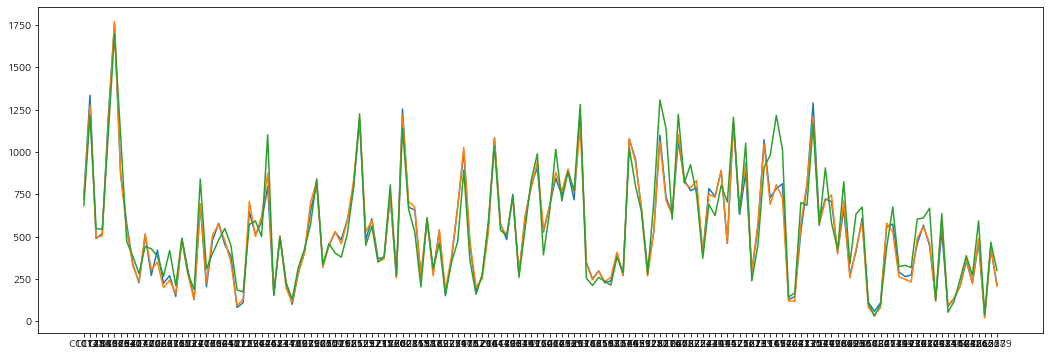

In [174]:
import matplotlib.pyplot as plt


best_score = pd.read_csv('./result/result6_3.csv')
danji_score = new_test['단지내주차면수']
current_score = pd.read_csv('./result/result7_3.csv')
print(mean_absolute_error(danji_score, current_score['num']))

plt.figure(figsize=(18,6))
plt.plot(best_score['code'], best_score['num'])
plt.plot(current_score['code'], current_score['num'])
plt.plot(best_score['code'], danji_score)
plt.show()